# Final Project

## Feature Prototype

### Project Idea 1: Deep Learning on a public dataset



In [1]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

In [2]:
# Importing Library to load the Dataset
from scipy.io import loadmat

# Change this names !!

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

Below, I am splitting up the dataset into training data and training labels

In [3]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

Below, I am checking the shape of each of the data and labels sets.

In [4]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Lables:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Lables: (26032, 1)


In [5]:
# Adapted From https://www.tensorflow.org/tutorials/load_data/images

# Import the matplotlib library for visualization
import matplotlib.pyplot as plt

def plot_sample_images(data, labels):

    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    for i in range(9):
        
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[:, :, :, i])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")


# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [6]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

In [7]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


There are 6000 samples in the dataset.

A function to Shuffle the datasets

In [8]:
def shuffle_dataset(data, labels):

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [9]:
X_val, y_val = shuffle_dataset(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [10]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)




print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [11]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [12]:
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

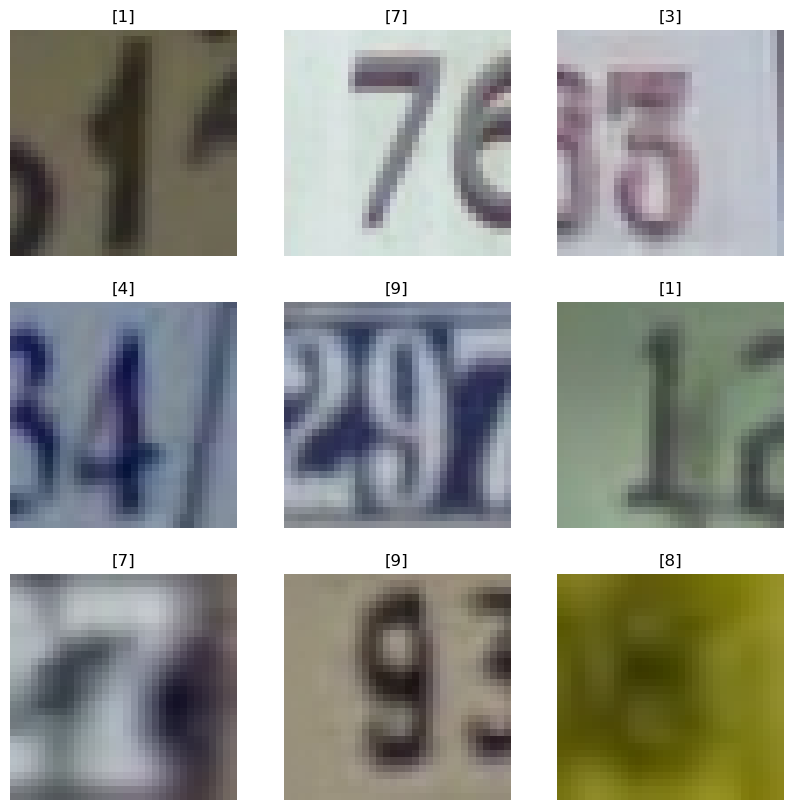

In [13]:
plot_sample_images(X_train_merge, y_train_merge)

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [14]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth)

In [15]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

Training data (598388, 32, 32, 3) Training Labels (598388, 1)
Validation data (6000, 32, 32, 3) 598388, 32, 32, Validation Labels (6000, 1)
Test data (26032, 32, 32, 3) Test Labels (26032, 1)


In [16]:
len(X_train_reshaped)

598388

## Normalization

Normalize the data to a common scale for more efficient training.

In [17]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calculate the mean and Variance
norm_layer.adapt(X_train_reshaped)

In [18]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.87014  109.69102  113.778694]]]]
Variance: [[[[2511.4565 2557.1646 2585.8994]]]]


Apply normalization to the training and validation sets.

In [19]:
# Normalize Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(X_train_reshaped)
    X_val_normalized = norm_layer(X_val_reshaped)

Checking the Images after normalization.

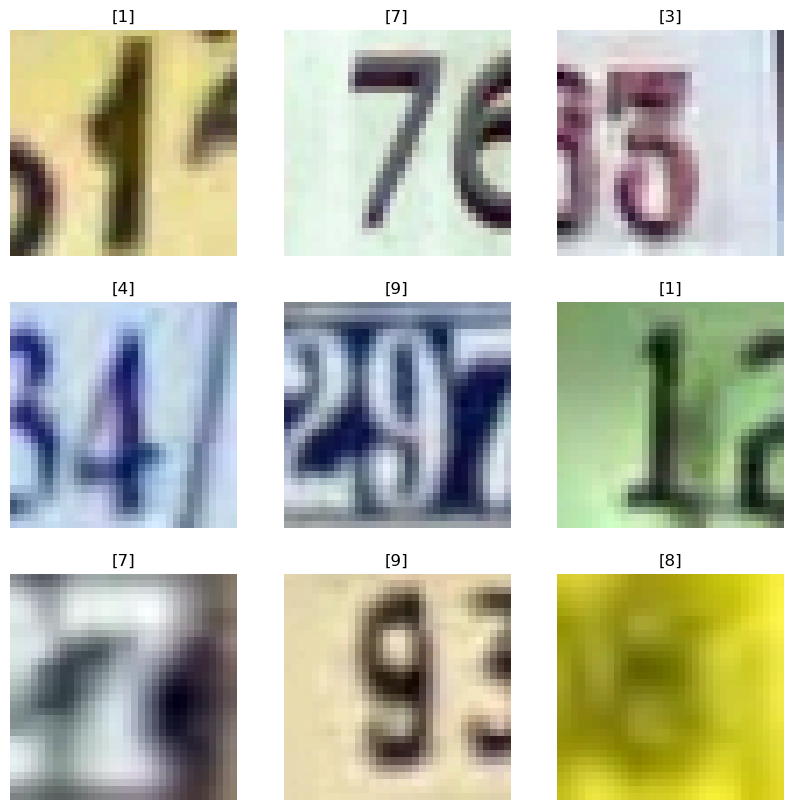

In [22]:

plt.figure(figsize=(10, 10))

# Loop over the first 9 images in the dataset
for i in range(9):
    
    # Create a subplot in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # https://stackoverflow.com/questions/1456000/rescaling-ranges
    rescaled_image = (X_train_normalized [i, :, :, :] - tf.reduce_min(
                          X_train_normalized [i, :, :, :])) / (tf.reduce_max(
                              X_train_normalized [i, :, :, :]) - tf.reduce_min(
                                  X_train_normalized [i, :, :, :]))

    # Display the i-th image from the 'train_data'    
    plt.imshow(rescaled_image)
    
    # Set the title of the subplot to the corresponding label in 'train_labels'
    plt.title(y_train_merge[i])
    
    # Turn off the axis to remove ticks and labels for a cleaner display
    plt.axis("off")


The images look brighter after normalization.

## Converting Labels to a One hot encoded array

I am using the 'categorical_crossentropy' loss function which expects one hot encoded values. First I will change the way the digit 0 is labelled. At the moment digit 0 is labelled as 10. I will re-label it a 0

In [23]:
# Convert 10 to 0 for all label sets

import numpy as np

# Replace label 10 with 0
y_train_relabelled = np.where(y_train_merge == 10, 0, y_train_merge)
y_val_relabelled = np.where(y_val == 10, 0, y_val)
y_test_relabelled = np.where(test_labels == 10, 0, test_labels)

# Validate the labels
print("Unique values in adjusted y_train_merge:", np.unique(y_train_relabelled ))
print("Unique values in adjusted y_val:", np.unique(y_val_relabelled ))
print("Unique values in adjusted test_labels:", np.unique(y_test_relabelled ))

Unique values in adjusted y_train_merge: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted y_val: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted test_labels: [0 1 2 3 4 5 6 7 8 9]


One hot encoded the labels below.

In [24]:
# Import module
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder ot the training labels
enc = OneHotEncoder().fit(y_train_relabelled)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(y_train_relabelled).toarray()
y_val_oh = enc.transform(y_val_relabelled).toarray()

Below, I am computing the class weights of the training data. This will be used with the classification model to make sure when the accuracy is calculated the imbalance is taken into account.

In [25]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
from sklearn.utils import class_weight


y_integers = np.argmax(y_train_oh, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

## Converting to Tensor

In [26]:
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train_oh))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, y_val_oh))


In [27]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Simple Classification Model

for the first evaluation I will compare 2 models with the same architecture but using differentr activation functions. I want to confirm if Maxout networks offer any benefits over the Relu function. Before I proceed in fine tuning and using more sophisticated techniques.

The first model I will use will be focussed around the model in Maxout Networks by (Ian J. Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron Courville, Yoshua Bengio) 2013. I will use the same structure of the model used in the paper but with the Relu activation function. In the second Model I will use the Maxout Activation function. The structure of both the model will be as follow:

1. Three Convolutional Layers:

    - As stated before the activation function will either be Maxout or Relu depending on the Model.

1. One Fully Connected Layer with activation function:

    - After the convolutional layers, a dense (fully connected) with either Maxout or Relu will be used.

1. One Fully Connected Softmax Layer:

    - A standard softmax layer is used at the output for final digit classification.

1. Dropout Regularization:

    - Dropout will be applied to each layer onf the model. I will use a setting of 0.2 for the convolutional layers and 0.5 for the dense layers.



In [28]:
# seed_test = tf.random.Generator.from_seed(1)
seed_test = tf.random.set_seed (None)
seed_test

In [29]:
from utils.DropBlock import DropBlock2D

# Small feature map shape for demonstration purposes:
features = tf.random.stateless_uniform((1, 4, 4, 1), seed=[0, 1])

print(features[..., 0])

layer = DropBlock2D(0.1, block_size=2, seed=1234)

output = layer(features, training=True)

print(output[..., 0])

tf.Tensor(
[[[0.08216608 0.40928006 0.39318466 0.3162533 ]
  [0.34717774 0.73199546 0.56369007 0.9769211 ]
  [0.55243933 0.13101244 0.2941643  0.5130266 ]
  [0.38977218 0.80855536 0.6040567  0.10502195]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor(
[[[0.10955477 0.54570675 0.5242462  0.42167106]
  [0.46290365 0.97599393 0.75158674 1.3025614 ]
  [0.         0.         0.39221907 0.6840355 ]
  [0.         0.         0.80540895 0.14002927]]], shape=(1, 4, 4), dtype=float32)


In [30]:
Stop Here !

SyntaxError: invalid syntax (3194995719.py, line 1)

## Model 1: Relu

In [85]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations
# from utils.old_DropBlock import DropBlock2D
import importlib
import utils.DropBlock
from utils.DropBlock import DropBlock2D
importlib.reload(utils.DropBlock)


# Build the model
model_Relu_dropblock = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
    # tf.keras.layers.Dropout(0.2),
    DropBlock2D(rate=0.5, block_size=3 ),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
    # tf.keras.layers.Dropout(0.2),
    DropBlock2D(rate=0.5, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
    # tf.keras.layers.Dropout(0.2),
    DropBlock2D(rate=0.5, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # DropBlock2D(rate=0.5, block_size=3),  


    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_Relu_dropblock.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_Relu_dropblock.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 drop_block2d_93 (DropBlock2  (None, 30, 30, 32)       0         
 D)                                                              
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 drop_block2d_94 (DropBlock2  (None, 13, 13, 64)       0         
 D)                                                              
                                                     

In [86]:
from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_dropblock_relu = model_Relu_dropblock.fit(
    # X_train_normalized_lcn, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized_lcn, y_val_oh),   # Validation data and labels
    validation_data=val_dataset,   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    # callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.3979 - accuracy: 0.8793 - val_loss: 0.2675 - val_accuracy: 0.9238
Epoch 2/100
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2305 - accuracy: 0.9323 - val_loss: 0.2288 - val_accuracy: 0.9350
Epoch 3/100
4675/4675 [==============================] - 37s 8ms/step - loss: 0.2087 - accuracy: 0.9391 - val_loss: 0.2170 - val_accuracy: 0.9363
Epoch 4/100
4675/4675 [==============================] - 35s 7ms/step - loss: 0.1977 - accuracy: 0.9425 - val_loss: 0.2141 - val_accuracy: 0.9402
Epoch 5/100
4675/4675 [==============================] - 35s 8ms/step - loss: 0.1922 - accuracy: 0.9440 - val_loss: 0.2111 - val_accuracy: 0.9485
Epoch 6/100
4675/4675 [==============================] - 35s 7ms/step - loss: 0.1866 - accuracy: 0.9457 - val_loss: 0.2051 - val_accuracy: 0.9445
Epoch 7/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.1823 - accuracy: 0.9471 - val_loss: 0.1959 -

In [100]:
np.save('Relu_history_dropblock.npy',model_Relu_dropblock.history)

In [220]:
model_Relu_dropblock.save("Relu_model_dropblock.keras")

## Model 3: Maxout Version 2

In [42]:
import tensorflow as tf
import tensorflow_addons as tfa
import importlib
import utils.DropBlock
from utils.DropBlock import DropBlock2D
importlib.reload(utils.DropBlock)

# Build the model
model_maxout_v2_dropblock = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=16),                   # Maxout layer
    DropBlock2D(rate=0.2, block_size=7 ),

    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=32),                  # Maxout layer
    DropBlock2D(rate=0.2, block_size=7 ),

    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=64),                   # Maxout layer
    DropBlock2D(rate=0.2, block_size=7 ),

       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),   
    tfa.layers.Maxout(num_units=64), 

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v2_dropblock.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v2_dropblock.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 maxout_32 (Maxout)          (None, 30, 30, 16)        0         
                                                                 
 drop_block2d_28 (DropBlock2  (None, 30, 30, 16)       0         
 D)                                                              
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        9280      
                                                                 
 maxout_33 (Maxout)          (None, 28, 28, 32)        0         
                                                                 
 drop_block2d_29 (DropBlock2  (None, 28, 28, 32)       0         
 D)                                                   

In [43]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_maxout_v2_dropblock = model_maxout_v2_dropblock.fit(
    # X_train_normalized, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    validation_data=(val_dataset),   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 110s 23ms/step - loss: 0.3063 - accuracy: 0.9113 - val_loss: 0.3037 - val_accuracy: 0.9207
Epoch 2/100
4675/4675 [==============================] - 109s 23ms/step - loss: 0.1784 - accuracy: 0.9487 - val_loss: 0.2836 - val_accuracy: 0.9293
Epoch 3/100
4675/4675 [==============================] - 109s 23ms/step - loss: 0.1579 - accuracy: 0.9541 - val_loss: 0.2944 - val_accuracy: 0.9307
Epoch 4/100
4675/4675 [==============================] - 110s 23ms/step - loss: 0.1435 - accuracy: 0.9581 - val_loss: 0.3048 - val_accuracy: 0.9253
Epoch 5/100
4675/4675 [==============================] - 109s 23ms/step - loss: 0.1339 - accuracy: 0.9607 - val_loss: 0.3159 - val_accuracy: 0.9308
Epoch 6/100
4675/4675 [==============================] - 109s 23ms/step - loss: 0.1280 - accuracy: 0.9620 - val_loss: 0.3590 - val_accuracy: 0.9280
Epoch 7/100
4675/4675 [==============================] - 110s 23ms/step - loss: 0.1204 - accuracy: 0.9640 - val_

In [108]:
np.save('maxout_history_v2_dropblock.npy',history_maxout_v2_dropblock.history)

In [223]:
model_maxout_v2_dropblock.save("model_maxout_v2_dropblock.keras")

# Results

In [88]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df_Relu_dropblock = pd.DataFrame(history_dropblock_relu.history) 
# hist_df_maxout_v1 = pd.DataFrame(history_maxout_v1.history) 
# hist_df_maxout_v2= pd.DataFrame(history_maxout_v2.history)

In [175]:
# Concatenate Datasets together and assign Dataset column with a label 

# concat_history = pd.concat([hist_df_Relu.assign(dataset='relu'), hist_df_maxout_v1.assign(dataset='maxout_v1'), hist_df_maxout_v2.assign(dataset='maxout_v2')])

In [89]:
# Function to the plot Training and Validation Scores

import matplotlib.pyplot as plt

def plot_accuracy_metric(dataframe, plotname):

    accuracy = dataframe["accuracy"]
    val_accuracy = dataframe["val_accuracy"]
    loss = dataframe["loss"]
    val_loss = dataframe["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # Subplot 1: Training and Validation Accuracy
    axes[0].plot(epochs, accuracy, "bo", label="Training accuracy")
    axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
    axes[0].set_title("Training and validation accuracy " + plotname)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    # plt.figure()
    # Subplot 2: Training and Validation Loss
    axes[1].plot(epochs, loss, "bo", label="Training loss")
    axes[1].plot(epochs, val_loss, "b", label="Validation loss")
    axes[1].set_title("Training and validation loss " + plotname)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

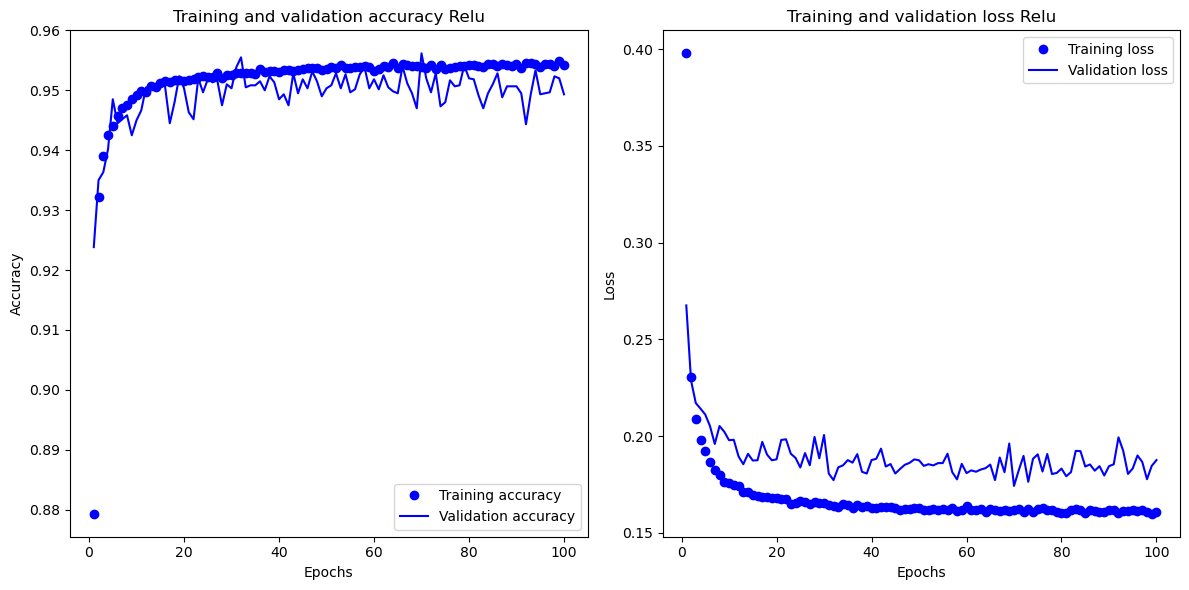

In [90]:
plot_accuracy_metric(hist_df_Relu_dropblock, 'Relu')
# plot_accuracy_metric(hist_df_maxout_v1, 'Maxout_v1')
# plot_accuracy_metric(hist_df_maxout_v2, 'Maxout_v2')

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix()

## Code Testing

In [21]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
from keras.utils import plot_model

plot_model(model_Relu, to_file='model_Relu.png')

In [ ]:
# Code taken from Deep Learning with Python, Second Edition Chapter 8 Listing 8.12

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# New parameters model
# model_07/12_12:00_epochs

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model_4 = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    # tf.keras.layers.Dropout(.1),              

    # tf.keras.layers.Conv2D(32, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),                              
    tf.keras.layers.Conv2D(1024, (5, 5), strides=(1, 1), padding="same"), 
    tf.keras.layers.Dropout(.5),                             
    tfa.layers.Maxout(num_units=2),                   
                     
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    

    # tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tf.keras.layers.Conv2D(2048, (5, 5), strides=(1, 1), padding="same"),  
    tf.keras.layers.Dropout(.5),             
    tfa.layers.Maxout(num_units=2),                   #
                      #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    

    # tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tf.keras.layers.Conv2D(4096, (5, 5), strides=(1, 1), padding="same"), 
    tf.keras.layers.Dropout(.5),             
    tfa.layers.Maxout(num_units=2),                   
                  
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    


    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128,kernel_constraint=max_norm(4)),   
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(.5),   
    tfa.layers.Maxout(num_units=2),
 
    
    # tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model_4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_4.summary()

In [ ]:
history = model_4.fit(
    X_train_normalized, y_train_oh,                # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),  # Validation data and labels
    batch_size=128,                   # Number of samples per batch
    epochs=100,                       # Number of epochs
    class_weight=d_class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

In [ ]:
# New Parameters Model

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(.1),              

    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),  
    tfa.layers.Maxout(num_units=2),                         
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)), 
    tfa.layers.Maxout(num_units=2),                       #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),                   
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),
  
    tf.keras.layers.Flatten(),
        
    tf.keras.layers.Dense(512,kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),
    # tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),

    

    tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model.summary()

In [ ]:
history = model.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=2048,                   # Number of samples per batch
    epochs=50,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)